In [1]:
import sys

In [2]:
sys.path.insert(0,'utils')
sys.path.insert(0,'../')

In [3]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib.patches import Ellipse

In [4]:
from helper_code import *
from get_feature import *
from utils.models import *
import sys
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import librosa
import librosa.display
import datetime
import tensorflow as tf
from sklearn.impute import SimpleImputer
from tqdm import tqdm

In [5]:
root_dir = '/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3'
training_data_file = root_dir +'/' + 'training_data.csv'
training_data_dir = root_dir + '/' + 'training_data'
model_dir = root_dir + '/' + 'model'

In [6]:
data_folder =  training_data_dir

In [7]:
patient_files = find_patient_files(data_folder)
num_patient_files = len(patient_files)
num_patient_files

942

In [8]:
data_folder =  'physionet.org/files/circor-heart-sound/1.0.3/training_data'
train_data_folder =  '/home/ubuntu/data/hmd/murmur/train'
test_data_folder = '/home/ubuntu/data/hmd/murmur/test'

In [9]:
patient_files_trn = find_patient_files(train_data_folder)
patient_files_test = find_patient_files(test_data_folder)

num_patient_files = len(patient_files_trn)
num_patient_files

751

In [10]:
current_patient_data = load_patient_data(patient_files[1])
current_patient_data

'9979 4 4000\nAV 9979_AV.hea 9979_AV.wav 9979_AV.tsv\nPV 9979_PV.hea 9979_PV.wav 9979_PV.tsv\nTV 9979_TV.hea 9979_TV.wav 9979_TV.tsv\nMV 9979_MV.hea 9979_MV.wav 9979_MV.tsv\n#Age: Child\n#Sex: Female\n#Height: 103.0\n#Weight: 13.1\n#Pregnancy status: False\n#Murmur: Present\n#Murmur locations: AV+MV+PV+TV\n#Most audible location: TV\n#Systolic murmur timing: Holosystolic\n#Systolic murmur shape: Diamond\n#Systolic murmur grading: III/VI\n#Systolic murmur pitch: High\n#Systolic murmur quality: Harsh\n#Diastolic murmur timing: nan\n#Diastolic murmur shape: nan\n#Diastolic murmur grading: nan\n#Diastolic murmur pitch: nan\n#Diastolic murmur quality: nan\n#Outcome: Abnormal\n#Campaign: CC2015\n#Additional ID: nan\n'

In [11]:
fnms = os.listdir(root_dir + '/training_data')

In [12]:
fnms_wav = [a for a in fnms if a.split('.')[1] == 'wav']
fname = root_dir + '/training_data/' + fnms_wav[1]
fname

'/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/13918_MV.wav'

In [13]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt                 # Librery to load .mat files
import peakutils                                # Librery to help in peak detection
from scipy import special

In [49]:
recordings = load_recordings(data_folder, current_patient_data)
recordings

[array([1653, 3815, 3101, ...,  187,  348,   53], dtype=int16),
 array([32596, 28290,  8851, ...,  6449,  6299,  7167], dtype=int16),
 array([   244,  -3588, -22579, ...,   -207,   -205,   -204], dtype=int16),
 array([5039, 5952, 5754, ...,  344,  229,   87], dtype=int16)]

In [50]:
per_sec = 4000*4

In [52]:
n_samp

7

In [53]:
##----------------------------------------------------------------------------
# FUNCTIONS: "execfile"
##----------------------------------------------------------------------------
''' This Function creates a time-vector for any signal given the sampling frequency
    and the duration of a signal'''
def time_vector(sampling_frequency,duration): 
	number_samples= sampling_frequency*duration;
	result=np.arange(1,duration/number_samples,duration-duration/number_samples);

	return result

##----------------------------------------------------------------------------
''' Derivate of an input signal as y[n]= x[n+1]- x[n-1] 
'''
def derivate (x):
	lenght=np.shape(x)				# Get the length of the vector		
	lenght=lenght[0];				# Get the value of the length
	y=np.zeros(lenght);				# Initializate derivate vector
	for i in range(lenght-1):
			y[i]=x[i+1]-x[i];		
	return y

##----------------------------------------------------------------------------
'''To normalized any vector\0-dimentional array in [-1,1] range, by divided the 
   vector by the maximun value of itself, substracting the mean value to the vector
   & dividing each value of the vector by the maximun value of itself 
'''
def vec_nor(x):
	lenght=np.shape(x)				# Get the length of the vector		
	lenght=lenght[0];				# Get the value of the length
	xMax=max(x);					# Get the maximun value of the vector
	nVec=np.zeros(lenght);			        # Initializate derivate vector
	for n in range(lenght):
		nVec[n]=x[n]/xMax;			
	nVec=nVec-np.mean(nVec);
	nVec=np.divide(nVec,np.max(nVec));
	return nVec
##----------------------------------------------------------------------------
'''
  FpassBand is the function that develop a pass band filter of the signal 'x' through the
  discrete convolution of this 'x' first with the coeficients of a High Pass Filter 'hp' and then
  with the discrete convolution of this result with a Low Pass Filter 'lp'
'''
def FpassBand(X,hp,lp):
        llp=np.shape(lp)	  	        # Get the length of the lowpass vector		
        llp=llp[0];				# Get the value of the length
        lhp=np.shape(hp)			# Get the length of the highpass vector		
        lhp=lhp[0];				# Get the value of the length	

        x=np.convolve(X,lp);		        # Disrete convolution 
        x=x[round(llp/2):round(-1-(llp/2))];
        x=x-(np.mean(x));
        x=x/np.max(x);
	
        y=np.convolve(x,hp);			# Disrete onvolution
        y=y[round((lhp/2)):round(-1-(lhp/2))];
        y=y-np.mean(y);
        y=y/np.max(y);

        x=np.convolve(y,lp);		        # Disrete convolution 
        x=x[round((llp/2)):round(-1-(llp/2))];
        x=x-(np.mean(x));
        x=x/np.max(x);
	
        y=np.convolve(x,hp);			# Disrete onvolution
        y=y[round((lhp/2)):round(-1-(lhp/2))];
        y=y-np.mean(y);
        y=y/np.max(y);
        
        y=vec_nor(y);				# Vector Normalizing
        
        return y

In [126]:
per_sec = 4000*1
min_dist=300

for i in range(100) :
    fname = root_dir + '/training_data/' + fnms_wav[i]
    print(fname)
    datos=sp.io.wavfile.read(fname)
    filtros=sio.loadmat('./Filters1')
    tmp_interval = []
    n_samp = len(datos[1])//per_sec



    for k in range(n_samp):
        X = datos[1][k*per_sec:(k+1)*per_sec]
        Fs= datos[0]
        Fpa20=filtros['Fpa20'];			        # High pass filter
        Fpa20=Fpa20[0];					# High pass filter
        Fpb100=filtros['Fpb100'];		        # Low-pass Filter
        Fpb100=Fpb100[0];				# Low-pass Filter
        Xf=FpassBand(X,Fpa20,Fpb100); 	                # Apply a passband filter
        Xf=vec_nor(Xf);			

    # Derivate of the Signal
        dX=derivate(Xf);				# Derivate of the signal
        dX=vec_nor(dX);					# Vector Normalizing
    # Square of the signal
        dy=np.square(Xf);
        dy=vec_nor(dy);

        size=np.shape(Xf)				# Rank or dimension of the array
        fil=size[0];					# Number of rows

        positive=np.zeros((1,fil+1));                   # Initializating Positives Values Vector 
        positive=positive[0];                           # Getting the Vector

        points=np.zeros((1,fil));                       # Initializating the all Peak Points Vector
        points=points[0];                               # Getting the point vector

        peaks=np.zeros((1,fil));                        # Initializating the s1-s1 Peak Vector
        peaks=peaks[0];                                 # Getting the point vector


        for i in range(0,fil):
            if dX[i]>0:
                positive[i]=1;
            else:
                positive[i]=0;

        for i in range(0,fil):
            if (positive[i]==1 and positive[i+1]==0):
                points[i]=Xf[i];
            else:
                points[i]=0;

        indexes=peakutils.indexes(points,thres=0.5/max(points), min_dist=min_dist);
        lenght=np.shape(indexes)			# Get the length of the index vector		
        lenght=lenght[0];				# Get the value of the index vector

        for i in range(0,lenght):
            p=indexes[i];
            peaks[p]=points[p];

        n=np.arange(0,fil);                            # Vector to the X axes (Number of Samples)
        indexes =indexes+(k*per_sec)    
        tmp_peaks = np.array(indexes)


        tmp_interval.extend(tmp_peaks)

    tmp_interval = np.array(tmp_interval)
    tmp_interval = np.diff(tmp_interval)
    print(tmp_interval)

/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/13918_AV.wav
[1145 1151 2274 1468  857 1447  857 1143 1128 1349  949 1324  994 2314
 2275 2313 2317 2282 2271  492  539 1254 1328  980 2243]
/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/13918_MV.wav
[1267 1050 2313  373 1912 2307 1253 1081 1221 1060 1186 1540 4178 1346
  435  527 1265  322  738 1245 1068 1266 1038 2315 1261 1073 1223 1057
 1279 1054 1272 1070 1167 1129 1237  701  349 2310 2301 1221 1054 2302
 1163 1145 1213 1056 1246 1054 1249 1067 2287 1231 1057 1191 1132 1228
 1069 1238 1042 1246 1045 1163 1147 1142 1121 1245 1037 1249 1046 1165
 1142 1233 1051 1176 1114 1259 1076 1228 1050 1187 1118 1262 1067 2274
 1255 1045 1252  830  441  505]
/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/13918_PV.wav
[2266 2253 1415  862 2285 2242 2267 1237 1039 1278  959 1309  953 2276
 2289 1301  945 1330  946 2290 2318]
/home/ubu

[3268  973  608  324  967  919  974 1096  969  950  962  923  965  957
 2198  982 1134  984  967  984  975 1022 1048  973 1000  976  961  974
  776  302  974 1037 1052  871  968 1012  975 1072  978 2035  995  973
  915  966  936  978 1011 1018  938  972  895  952  917  950]
/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/2530_AV.wav
[1185  887 1195 1084 1105  540  549 1144  870 1092  929 1067 1070  481
  623 1071  855  551 1100 1057  981 1026  329  892 1240 1015   96 1259
  990  841  342 1100  644  581  973  406  686  117  893 1395 1006 1239
 1104 1334 1120 1187  875  409  786  884 1067 1110 1037 2921  505 1505
 1788  741 1820 1084  638  793  755 1321 1030 1019  436 1011 1299 1013
  572  584 4487 1021  523  704  593  392 3105 1023 1053 1008 1126  996
 1131  984 1972 1036  994 1025]
/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/2530_MV.wav
[ 746  352  359  762  580  432  578  337  330  478 1023  636 1104   35


[ 317  651  515  687 1118 1007 1895 1918 1099 1095  555 1262  370  799
 1729 2905  898 2263 3320 3351 1107 1916 1083  186 1751 1161 2079 3220
 2851 1141 1788 2866 1164 1736 2725 2705 2612 2544 2478 2743 2739 2210
  768 3001 2938]
/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/36327_PV.wav
[ 372 1822  927 1705  922 1963  933 2207  930 2314  939 2045  925 1932
  110  939 1742  474  945 2337  951 1336  777  940 1981  940 2120  960
 2089  966 2151  967 1949  954 1949  967 2184  968 2220  972 2141  960
  373 1475 1088 1907  965 2099  961 2428  959 2226  952 1993  945 2053
  376  582]
/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/36327_TV.wav
[3010 1206 1771 1091 1852 1214 1759 3156 3314 3048 1089 1453  565 1101
  811 1298  110  994 2174  973 1903 3092 3127 1089 2023 1084 1780 1077
 1836 3168 3127 1086 1885 1081 1830 3165 3147 1085 1813 2963]
/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/

[ 400  843  397  581 1333 1001 1456  917 1307 1173 1398  478  339 1141
 3150 4616  932 1524  498  272 1319  935  441  414  418  991  390  884
  913 1147  916 1124 1015 1497  969 1720  961 1254  879 1365  341  307
  382  784  578 1107 1023  360  999 1141  928 1387 1030 1545 1045 1354
  401  604  995  234  961 1665  926 2141 1053 2112 4565  946 1531  838
 1296  417  378  419]
/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/40798_PV.wav
[ 864  945  327  320  542 1165  972 1172  967 1367  848 1132  929 1195
  958 1272  968 1333  829 1150  945 1274  960 1366  975 2220 1352  851
 1457  979 1441  980 1272  945 1260  971 1461  979 1511  987 2212 1308
  984 1395  984 1450  982 2192 1397  990 1429  988 1298  966 1205  970
 1385  984 1516  992 1257  403  553 1216  344  635 1299  982 1372  980
 2135 1192  972 1117]
/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/40798_TV.wav
[ 539  632  381  912  878 1357 2274  889 1567  8

[1309 1090 1393 2492 1054 1301 1077 1374 1006 1476 2445 1026  444  836
 1089 1288  469  619 1384 2373 1073 1313  367  721 1477 1084  905  451
 1044 1120 1163 1093  473  701  503  687  745  420  687  600 1144 1225
  958 1269 1068 1229  398  674  580  684 2215  334  737 1116 1086 1367]
/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/46065_MV.wav
[ 770 1167 1266 1173 1872 1168 1297 1178 1141 1160 1071 1173 1145 1177
 1357 1173 1195 1156 1055 1163 1016 1169 1185 1162 1234 1153 1061 1145
  980 1161 1005 1162 1198 1159 1087 1144  968 1154  989 1157 1217 1173
 1302 1143 1042 1145 1017 1160 1223 1160 1239 1152 1121 1135 2160 1059
  399  750 2358 1066 1126 1779]
/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/46065_PV.wav
[ 905 1057 1079 1150 1078 1274 1052 1176 1062 1117  149  932 1311 1078
 1517 1067 1263 1052 1252  921 1072 1135 1331 1075 1410 1065 1147 1067
 1104 1086 1407 1081 1442 1064 1132 1075 1095 1087 1377 109

KeyboardInterrupt: 

In [193]:

def get_interval(datos, per_sec) :
#    datos=sp.io.wavfile.read(fname)
    filtros=sio.loadmat('./Filters1')
    tmp_interval = []
    n_samp = len(datos[1])//per_sec


    for k in range(n_samp):
        X = datos[1][k*per_sec:(k+1)*per_sec]
        Fs= datos[0]
        Fpa20=filtros['Fpa20'];			        # High pass filter
        Fpa20=Fpa20[0];					# High pass filter
        Fpb100=filtros['Fpb100'];		        # Low-pass Filter
        Fpb100=Fpb100[0];				# Low-pass Filter
        Xf=FpassBand(X,Fpa20,Fpb100); 	                # Apply a passband filter
        Xf=vec_nor(Xf);			

    # Derivate of the Signal
        dX=derivate(Xf);				# Derivate of the signal
        dX=vec_nor(dX);					# Vector Normalizing
    # Square of the signal
        dy=np.square(Xf);
        dy=vec_nor(dy);

        size=np.shape(Xf)				# Rank or dimension of the array
        fil=size[0];					# Number of rows

        positive=np.zeros((1,fil+1));                   # Initializating Positives Values Vector 
        positive=positive[0];                           # Getting the Vector

        points=np.zeros((1,fil));                       # Initializating the all Peak Points Vector
        points=points[0];                               # Getting the point vector

        peaks=np.zeros((1,fil));                        # Initializating the s1-s1 Peak Vector
        peaks=peaks[0];                                 # Getting the point vector


        for i in range(0,fil):
            if dX[i]>0:
                positive[i]=1;
            else:
                positive[i]=0;

        for i in range(0,fil):
            if (positive[i]==1 and positive[i+1]==0):
                points[i]=Xf[i];
            else:
                points[i]=0;

        indexes=peakutils.indexes(points,thres=0.5/max(points), min_dist=min_dist);
        lenght=np.shape(indexes)			# Get the length of the index vector		
        lenght=lenght[0];				# Get the value of the index vector

        for i in range(0,lenght):
            p=indexes[i];
            peaks[p]=points[p];

        n=np.arange(0,fil);                            # Vector to the X axes (Number of Samples)
        indexes =indexes+(k*per_sec)    
        tmp_peaks = np.array(indexes)


        tmp_interval.extend(tmp_peaks)

    tmp_interval = np.array(tmp_interval)
    return tmp_interval

In [191]:
fnms_wav[i]

'13918_MV.wav'

In [197]:
len(datos[1])

84608

AV 13918_AV.wav
[ 3555  5829  7297  8154 10458 11601 12729 14078 15027 17345 21934 24247
 26564 28846 31117 31609]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


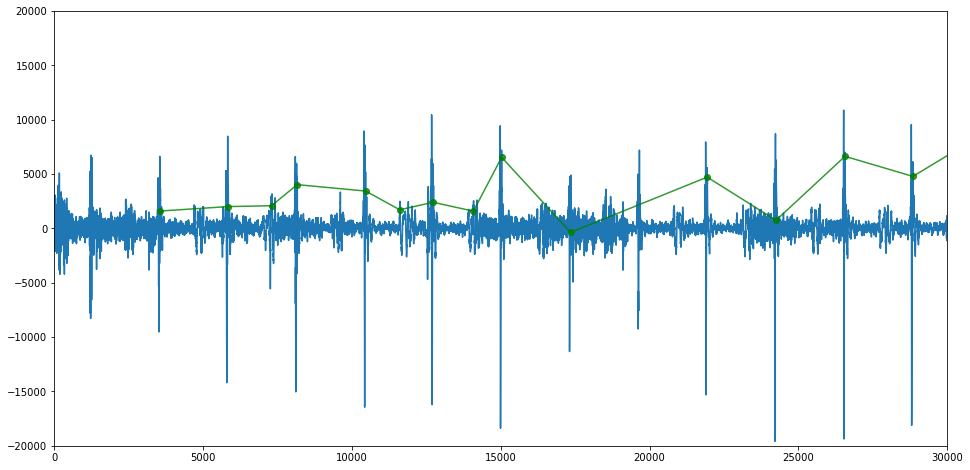

PV 13918_PV.wav
[ 1562  3828  6081  7496  8358 10643 12885 15152 17428 19665 20974 21927
 24203 26492 27793 28738 30068 31014]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


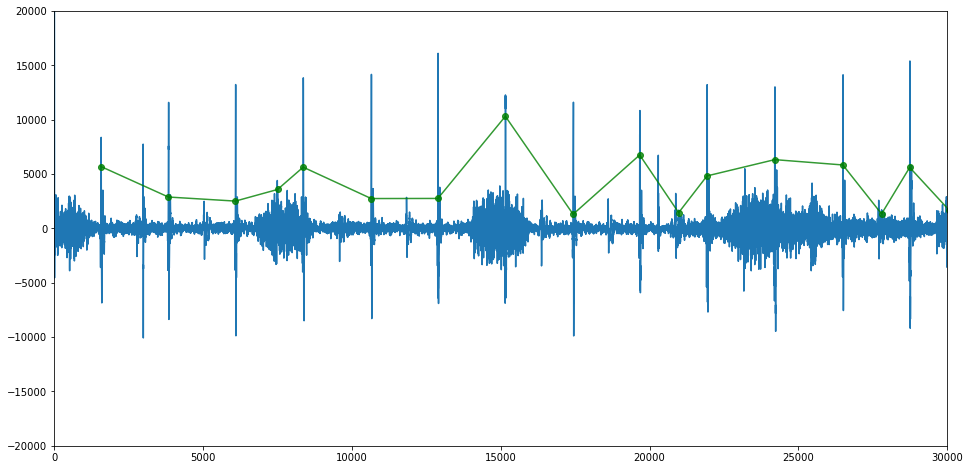

TV 13918_TV.wav
[  613  1660  2874  3905  6179  8432  9638 10669 11893 12928 15202]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


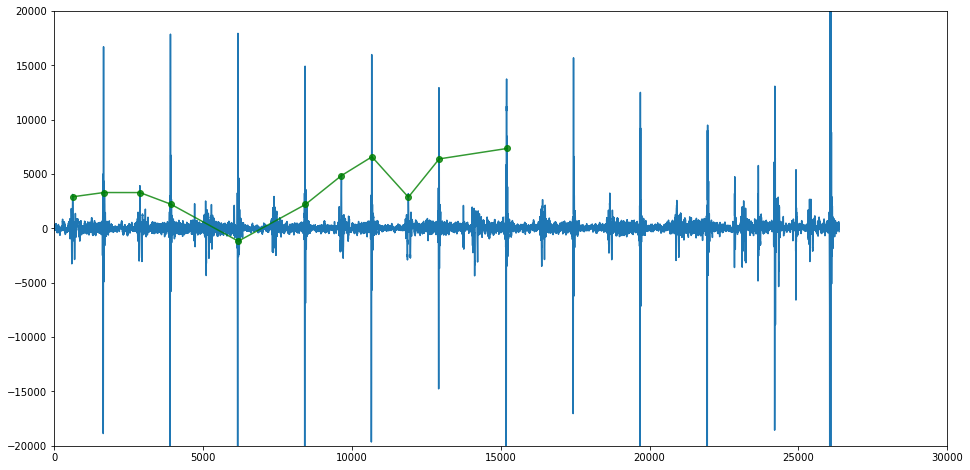

MV 13918_MV.wav
[   191   1458   2508   4821   5194   7106   9413  10666  11747  14028
  15214  16754  17573  20932  23240  27878  30182  32497  33758  34831
  36054  37111  38390  39444  40716  41786  42953  44082  45319  46020
  46369  48679  49915  50980  52201  53255  55557  56720  57865  59078
  60134  61380  62434  63683  64750  67037  68268  69325  70516  71648
  72876  73945  75183  76225  77471  78516  79679  80826  81968  83089
  84334  85371  86620  87666  88831  89973  91206  92257  93433  94547
  95806  96882  99160 100347 101465 103794 106068 107323 108368 109620
 110450 110891 111396]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


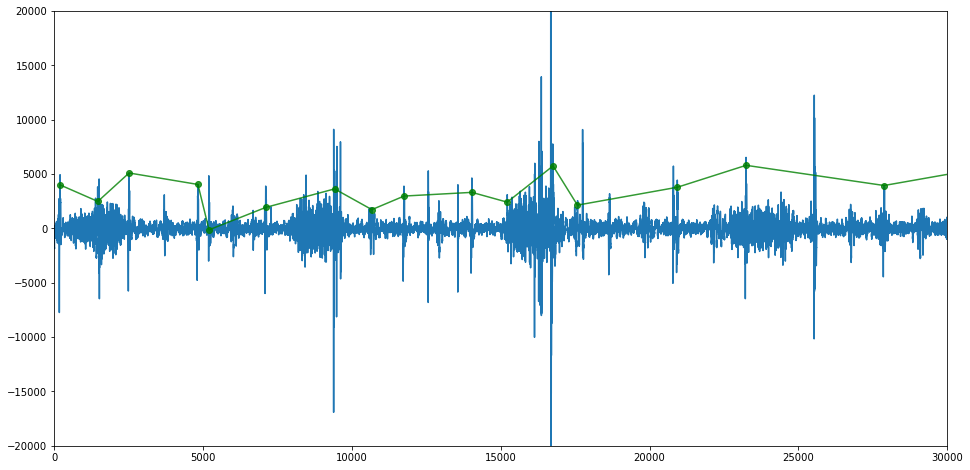

In [205]:
per_sec = 4000*4

current_patient_data = load_patient_data(patient_files[3])

spp = current_patient_data.split("\n")
data = {}
for l in spp :
    if l.startswith('AV '):
        data['AV'] = l.split(" ")[2]
    if l.startswith('PV '):
        data['PV'] = l.split(" ")[2]
    if l.startswith('TV '):
        data['TV'] = l.split(" ")[2]
    if l.startswith('MV '):
        data['MV'] = l.split(" ")[2]

for k,itm in data.items() :
    print(k,itm)
    fname = root_dir + '/training_data/' + itm
    datos=sp.io.wavfile.read(fname)
    interval1 = get_interval(datos, per_sec)
    print(interval1)
    print(np.diff(tmp_interval))
    
    seq1 = np.array(datos[1])
    plt.figure(figsize=(16,8))
    plt.plot(datos[1])
    plt.plot(interval1, datos[1][interval1], marker="o", c='green', alpha=.8 )
    plt.xlim(0,30000)
    plt.ylim(-20000,20000)
    plt.show()

In [127]:
i = 0
fname = root_dir + '/training_data/' + fnms_wav[i]
print(fname)
datos=sp.io.wavfile.read(fname)
filtros=sio.loadmat('./Filters1')
tmp_interval = []
n_samp = len(datos[1])//per_sec


for k in range(n_samp):
    X = datos[1][k*per_sec:(k+1)*per_sec]
    Fs= datos[0]
    Fpa20=filtros['Fpa20'];			        # High pass filter
    Fpa20=Fpa20[0];					# High pass filter
    Fpb100=filtros['Fpb100'];		        # Low-pass Filter
    Fpb100=Fpb100[0];				# Low-pass Filter
    Xf=FpassBand(X,Fpa20,Fpb100); 	                # Apply a passband filter
    Xf=vec_nor(Xf);			

# Derivate of the Signal
    dX=derivate(Xf);				# Derivate of the signal
    dX=vec_nor(dX);					# Vector Normalizing
# Square of the signal
    dy=np.square(Xf);
    dy=vec_nor(dy);

    size=np.shape(Xf)				# Rank or dimension of the array
    fil=size[0];					# Number of rows

    positive=np.zeros((1,fil+1));                   # Initializating Positives Values Vector 
    positive=positive[0];                           # Getting the Vector

    points=np.zeros((1,fil));                       # Initializating the all Peak Points Vector
    points=points[0];                               # Getting the point vector

    peaks=np.zeros((1,fil));                        # Initializating the s1-s1 Peak Vector
    peaks=peaks[0];                                 # Getting the point vector


    for i in range(0,fil):
        if dX[i]>0:
            positive[i]=1;
        else:
            positive[i]=0;

    for i in range(0,fil):
        if (positive[i]==1 and positive[i+1]==0):
            points[i]=Xf[i];
        else:
            points[i]=0;

    indexes=peakutils.indexes(points,thres=0.5/max(points), min_dist=min_dist);
    lenght=np.shape(indexes)			# Get the length of the index vector		
    lenght=lenght[0];				# Get the value of the index vector

    for i in range(0,lenght):
        p=indexes[i];
        peaks[p]=points[p];

    n=np.arange(0,fil);                            # Vector to the X axes (Number of Samples)
    indexes =indexes+(k*per_sec)    
    tmp_peaks = np.array(indexes)


    tmp_interval.extend(tmp_peaks)

tmp_interval = np.array(tmp_interval)

/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/13918_AV.wav


In [128]:
datos[1]

array([   0,   33,  302, ..., -357,  -76,  513], dtype=int16)

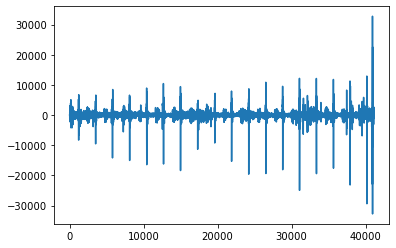

In [129]:
import matplotlib.pyplot as plt

plt.plot(datos[1])
plt.show()

In [130]:
tmp_interval

array([ 1259,  2404,  3555,  5829,  7297,  8154,  9601, 10458, 11601,
       12729, 14078, 15027, 16351, 17345, 19659, 21934, 24247, 26564,
       28846, 31117, 31609, 32148, 33402, 34730, 35710, 37953])

In [131]:
seq1 = np.array(datos[1])

In [132]:
seq1[tmp_interval]

array([3367, 2276, 1594, 2003, 2081, 4022, 1389, 3430, 1710, 2399, 1580,
       6534, 1448, -368, 4299, 4712,  740, 6627, 4780, 8534, 4573, 6178,
        596, 2047, 5732, 9629], dtype=int16)

## AV

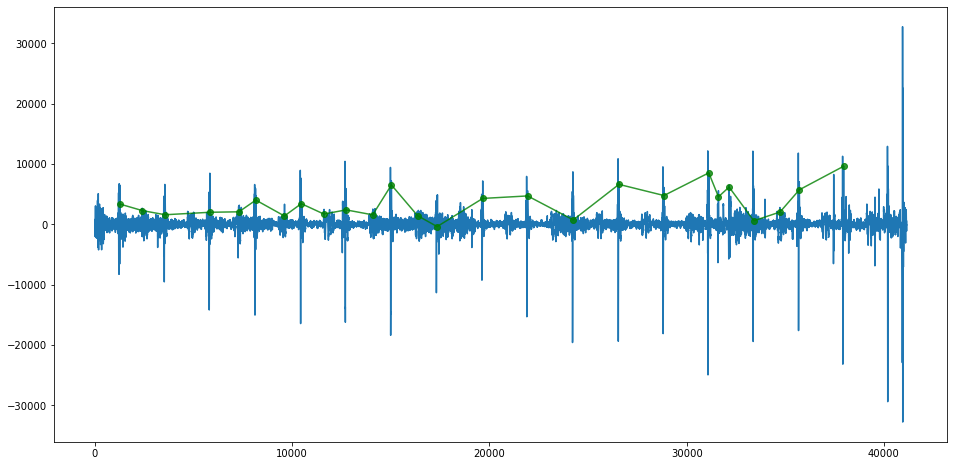

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(datos[1])
plt.plot(tmp_interval, seq1[tmp_interval], marker="o", c='green', alpha=.8 )
plt.show()

In [134]:
tmp_interval2 = np.diff(tmp_interval)

In [135]:
tmp_interval2

array([1145, 1151, 2274, 1468,  857, 1447,  857, 1143, 1128, 1349,  949,
       1324,  994, 2314, 2275, 2313, 2317, 2282, 2271,  492,  539, 1254,
       1328,  980, 2243])

In [136]:
tmp_interval

array([ 1259,  2404,  3555,  5829,  7297,  8154,  9601, 10458, 11601,
       12729, 14078, 15027, 16351, 17345, 19659, 21934, 24247, 26564,
       28846, 31117, 31609, 32148, 33402, 34730, 35710, 37953])

In [137]:
i = 1
fname = root_dir + '/training_data/' + fnms_wav[i]
print(fname)
datos=sp.io.wavfile.read(fname)
filtros=sio.loadmat('./Filters1')
tmp_interval = []
n_samp = len(datos[1])//per_sec



for k in range(n_samp):
    X = datos[1][k*per_sec:(k+1)*per_sec]
    Fs= datos[0]
    Fpa20=filtros['Fpa20'];			        # High pass filter
    Fpa20=Fpa20[0];					# High pass filter
    Fpb100=filtros['Fpb100'];		        # Low-pass Filter
    Fpb100=Fpb100[0];				# Low-pass Filter
    Xf=FpassBand(X,Fpa20,Fpb100); 	                # Apply a passband filter
    Xf=vec_nor(Xf);			

# Derivate of the Signal
    dX=derivate(Xf);				# Derivate of the signal
    dX=vec_nor(dX);					# Vector Normalizing
# Square of the signal
    dy=np.square(Xf);
    dy=vec_nor(dy);

    size=np.shape(Xf)				# Rank or dimension of the array
    fil=size[0];					# Number of rows

    positive=np.zeros((1,fil+1));                   # Initializating Positives Values Vector 
    positive=positive[0];                           # Getting the Vector

    points=np.zeros((1,fil));                       # Initializating the all Peak Points Vector
    points=points[0];                               # Getting the point vector

    peaks=np.zeros((1,fil));                        # Initializating the s1-s1 Peak Vector
    peaks=peaks[0];                                 # Getting the point vector


    for i in range(0,fil):
        if dX[i]>0:
            positive[i]=1;
        else:
            positive[i]=0;

    for i in range(0,fil):
        if (positive[i]==1 and positive[i+1]==0):
            points[i]=Xf[i];
        else:
            points[i]=0;

    indexes=peakutils.indexes(points,thres=0.5/max(points), min_dist=min_dist);
    lenght=np.shape(indexes)			# Get the length of the index vector		
    lenght=lenght[0];				# Get the value of the index vector

    for i in range(0,lenght):
        p=indexes[i];
        peaks[p]=points[p];

    n=np.arange(0,fil);                            # Vector to the X axes (Number of Samples)
    indexes =indexes+(k*per_sec)    
    tmp_peaks = np.array(indexes)


    tmp_interval.extend(tmp_peaks)

tmp_interval = np.array(tmp_interval)

/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/13918_MV.wav


In [138]:
datos[1]

array([-1812, -1872,  -547, ...,  -937,  -894,  -592], dtype=int16)

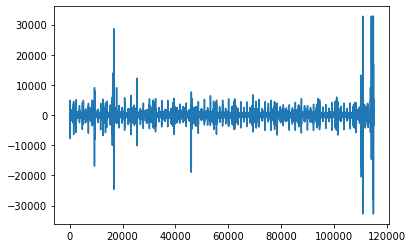

In [139]:
import matplotlib.pyplot as plt

plt.plot(datos[1])
plt.show()

In [140]:
tmp_interval

array([   191,   1458,   2508,   4821,   5194,   7106,   9413,  10666,
        11747,  12968,  14028,  15214,  16754,  20932,  22278,  22713,
        23240,  24505,  24827,  25565,  26810,  27878,  29144,  30182,
        32497,  33758,  34831,  36054,  37111,  38390,  39444,  40716,
        41786,  42953,  44082,  45319,  46020,  46369,  48679,  50980,
        52201,  53255,  55557,  56720,  57865,  59078,  60134,  61380,
        62434,  63683,  64750,  67037,  68268,  69325,  70516,  71648,
        72876,  73945,  75183,  76225,  77471,  78516,  79679,  80826,
        81968,  83089,  84334,  85371,  86620,  87666,  88831,  89973,
        91206,  92257,  93433,  94547,  95806,  96882,  98110,  99160,
       100347, 101465, 102727, 103794, 106068, 107323, 108368, 109620,
       110450, 110891, 111396])

In [141]:
seq1 = np.array(datos[1])

In [142]:
seq1[tmp_interval]

array([ 3994,  2476,  5094,  4039,  -135,  1932,  3630,  1723,  2971,
        1096,  3311,  2410,  5745,  3782,  1495,   779,  5798,  2297,
        1533,  2224,  1303,  3942,   119,  5053,  3606,  1627,  4062,
         805,  4116,  1516,  4441,  2059,  2983,  1320,  3813,  1184,
        7180,  5087,  2731,  5210,  1940,  5815,  3013,  2256,  4304,
         733,  4939,  1010,  5359,  1565,  4416,  3273,   674,  5187,
        2277,  4837,  2023,  1634,    63,  3365,  3773,  2662,  1948,
        1204,  1965,  2427,   167,  3014,  1077,  5244,   353,  1469,
        1583,  2981,  -142,  2272,  2254,  1277,  2051,  2430,  3123,
        -100,  1684,   756,  2650,   466,  1956,  2219,  5387, 30230,
        1369], dtype=int16)

## MV

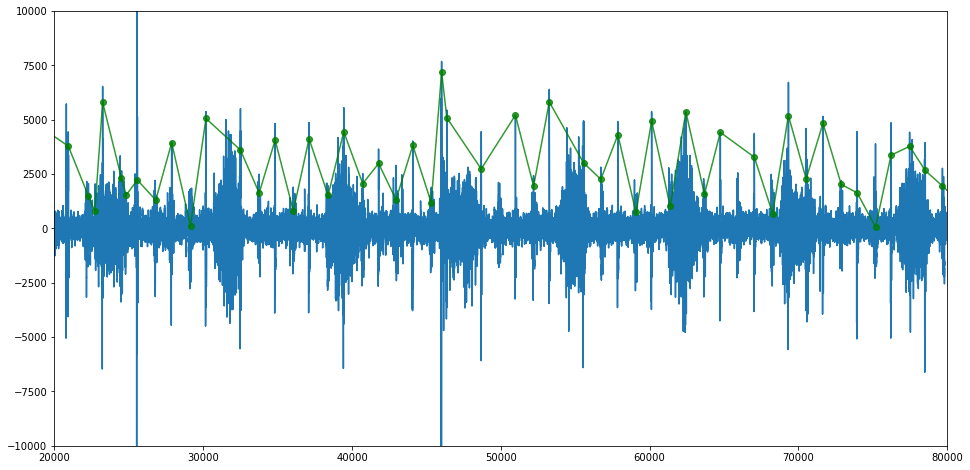

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(datos[1])
plt.plot(tmp_interval, seq1[tmp_interval], marker="o", c='green', alpha=.8 )
plt.xlim(20000,80000)
plt.ylim(-10000,10000)
plt.show()

In [147]:
tmp_interval2 = np.diff(tmp_interval)

In [148]:
tmp_interval2

array([1267, 1050, 2313,  373, 1912, 2307, 1253, 1081, 1221, 1060, 1186,
       1540, 4178, 1346,  435,  527, 1265,  322,  738, 1245, 1068, 1266,
       1038, 2315, 1261, 1073, 1223, 1057, 1279, 1054, 1272, 1070, 1167,
       1129, 1237,  701,  349, 2310, 2301, 1221, 1054, 2302, 1163, 1145,
       1213, 1056, 1246, 1054, 1249, 1067, 2287, 1231, 1057, 1191, 1132,
       1228, 1069, 1238, 1042, 1246, 1045, 1163, 1147, 1142, 1121, 1245,
       1037, 1249, 1046, 1165, 1142, 1233, 1051, 1176, 1114, 1259, 1076,
       1228, 1050, 1187, 1118, 1262, 1067, 2274, 1255, 1045, 1252,  830,
        441,  505])

In [150]:
i = 2
fname = root_dir + '/training_data/' + fnms_wav[i]
print(fname)
datos=sp.io.wavfile.read(fname)
filtros=sio.loadmat('./Filters1')
tmp_interval = []
n_samp = len(datos[1])//per_sec



for k in range(n_samp):
    X = datos[1][k*per_sec:(k+1)*per_sec]
    Fs= datos[0]
    Fpa20=filtros['Fpa20'];			        # High pass filter
    Fpa20=Fpa20[0];					# High pass filter
    Fpb100=filtros['Fpb100'];		        # Low-pass Filter
    Fpb100=Fpb100[0];				# Low-pass Filter
    Xf=FpassBand(X,Fpa20,Fpb100); 	                # Apply a passband filter
    Xf=vec_nor(Xf);			

# Derivate of the Signal
    dX=derivate(Xf);				# Derivate of the signal
    dX=vec_nor(dX);					# Vector Normalizing
# Square of the signal
    dy=np.square(Xf);
    dy=vec_nor(dy);

    size=np.shape(Xf)				# Rank or dimension of the array
    fil=size[0];					# Number of rows

    positive=np.zeros((1,fil+1));                   # Initializating Positives Values Vector 
    positive=positive[0];                           # Getting the Vector

    points=np.zeros((1,fil));                       # Initializating the all Peak Points Vector
    points=points[0];                               # Getting the point vector

    peaks=np.zeros((1,fil));                        # Initializating the s1-s1 Peak Vector
    peaks=peaks[0];                                 # Getting the point vector


    for i in range(0,fil):
        if dX[i]>0:
            positive[i]=1;
        else:
            positive[i]=0;

    for i in range(0,fil):
        if (positive[i]==1 and positive[i+1]==0):
            points[i]=Xf[i];
        else:
            points[i]=0;

    indexes=peakutils.indexes(points,thres=0.5/max(points), min_dist=min_dist);
    lenght=np.shape(indexes)			# Get the length of the index vector		
    lenght=lenght[0];				# Get the value of the index vector

    for i in range(0,lenght):
        p=indexes[i];
        peaks[p]=points[p];

    n=np.arange(0,fil);                            # Vector to the X axes (Number of Samples)
    indexes =indexes+(k*per_sec)    
    tmp_peaks = np.array(indexes)


    tmp_interval.extend(tmp_peaks)

tmp_interval = np.array(tmp_interval)

/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/13918_PV.wav


In [151]:
datos[1]

array([20835, 17880,  5868, ...,   -18,   -27,   -97], dtype=int16)

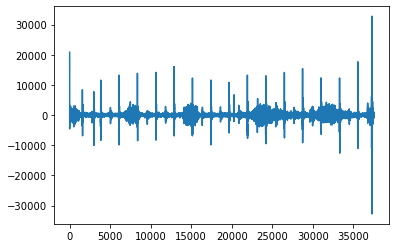

In [152]:
import matplotlib.pyplot as plt

plt.plot(datos[1])
plt.show()

In [153]:
tmp_interval

array([ 1562,  3828,  6081,  7496,  8358, 10643, 12885, 15152, 16389,
       17428, 18706, 19665, 20974, 21927, 24203, 26492, 27793, 28738,
       30068, 31014, 33304, 35622])

In [154]:
seq1 = np.array(datos[1])

In [155]:
seq1[tmp_interval]

array([ 5688,  2882,  2508,  3576,  5628,  2742,  2752, 10308,  2425,
        1297,  1039,  6750,  1446,  4823,  6321,  5831,  1332,  5605,
        1660,  4882,  5306,  4594], dtype=int16)

## PV

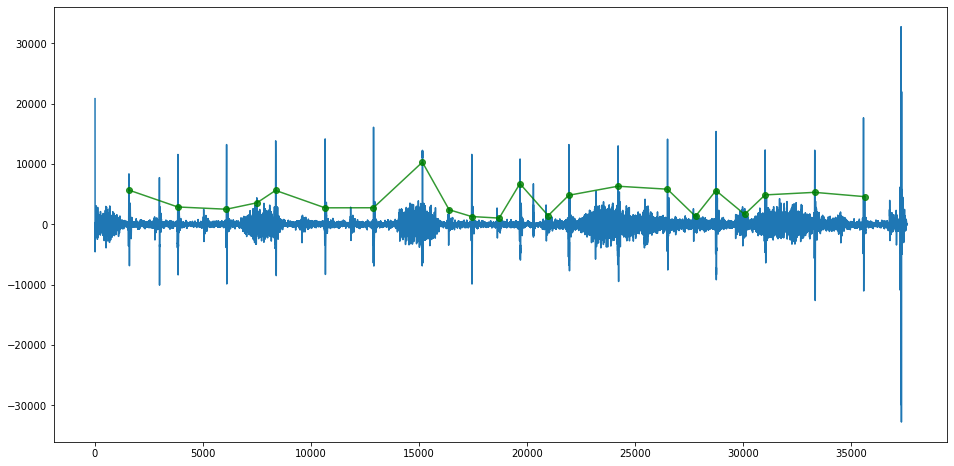

In [156]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(datos[1])
plt.plot(tmp_interval, seq1[tmp_interval], marker="o", c='green', alpha=.8 )
plt.show()

In [157]:
tmp_interval2 = np.diff(tmp_interval)

In [158]:
tmp_interval2

array([2266, 2253, 1415,  862, 2285, 2242, 2267, 1237, 1039, 1278,  959,
       1309,  953, 2276, 2289, 1301,  945, 1330,  946, 2290, 2318])

In [171]:
i = 5
fname = root_dir + '/training_data/' + fnms_wav[i]
print(fname)
datos=sp.io.wavfile.read(fname)
filtros=sio.loadmat('./Filters1')
tmp_interval = []
n_samp = len(datos[1])//per_sec



for k in range(n_samp):
    X = datos[1][k*per_sec:(k+1)*per_sec]
    Fs= datos[0]
    Fpa20=filtros['Fpa20'];			        # High pass filter
    Fpa20=Fpa20[0];					# High pass filter
    Fpb100=filtros['Fpb100'];		        # Low-pass Filter
    Fpb100=Fpb100[0];				# Low-pass Filter
    Xf=FpassBand(X,Fpa20,Fpb100); 	                # Apply a passband filter
    Xf=vec_nor(Xf);			

# Derivate of the Signal
    dX=derivate(Xf);				# Derivate of the signal
    dX=vec_nor(dX);					# Vector Normalizing
# Square of the signal
    dy=np.square(Xf);
    dy=vec_nor(dy);

    size=np.shape(Xf)				# Rank or dimension of the array
    fil=size[0];					# Number of rows

    positive=np.zeros((1,fil+1));                   # Initializating Positives Values Vector 
    positive=positive[0];                           # Getting the Vector

    points=np.zeros((1,fil));                       # Initializating the all Peak Points Vector
    points=points[0];                               # Getting the point vector

    peaks=np.zeros((1,fil));                        # Initializating the s1-s1 Peak Vector
    peaks=peaks[0];                                 # Getting the point vector


    for i in range(0,fil):
        if dX[i]>0:
            positive[i]=1;
        else:
            positive[i]=0;

    for i in range(0,fil):
        if (positive[i]==1 and positive[i+1]==0):
            points[i]=Xf[i];
        else:
            points[i]=0;

    indexes=peakutils.indexes(points,thres=0.5/max(points), min_dist=min_dist);
    lenght=np.shape(indexes)			# Get the length of the index vector		
    lenght=lenght[0];				# Get the value of the index vector

    for i in range(0,lenght):
        p=indexes[i];
        peaks[p]=points[p];

    n=np.arange(0,fil);                            # Vector to the X axes (Number of Samples)
    indexes =indexes+(k*per_sec)    
    tmp_peaks = np.array(indexes)


    tmp_interval.extend(tmp_peaks)

tmp_interval = np.array(tmp_interval)

/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/14241_MV.wav


In [172]:
datos[1]

array([2425, 1888, 1320, ..., -108,  -63,  -41], dtype=int16)

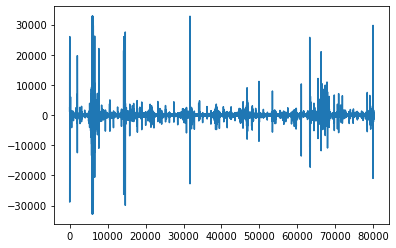

In [173]:
import matplotlib.pyplot as plt

plt.plot(datos[1])
plt.show()

In [174]:
tmp_interval

array([    5,  1920,  5952,  7769,  8424,  9373, 10508, 14215, 16857,
       17864, 18471, 18988, 19713, 21186, 23217, 25515, 27437, 28513,
       29752, 30156, 30732, 31827, 32276, 32811, 33991, 36175, 37249,
       38530, 39410, 40489, 41077, 41538, 42013, 42357, 42780, 43272,
       43604, 45037, 46282, 49001, 49543, 49959, 50470, 51105, 52102,
       53223, 54298, 55413, 56475, 57459, 58424, 59513, 63424, 66357,
       67417, 67800, 68207, 68570, 68889, 69280, 69658, 69980, 70552,
       70999, 71600, 72287, 72709, 73625, 74828, 75593, 75987, 77992,
       79925])

In [175]:
seq1 = np.array(datos[1])

In [176]:
seq1[tmp_interval]

array([ 3876,   330, 20852,  2620,  2020,   267,   131,  -171,  1869,
        1143,   393,  4328,   482,  2444,   804,   743,  1231,   220,
        1193,    10,  1552,  2179,   748,   535,  1191,  1024,   261,
         901,   172,  2492,   432,   709,   622,   820,   457,   172,
         297,  1951,  1206,   122,   379,   159,    84,   486,   -51,
         776,   556,   928,   196,   422,   -34,   570,  5933,   114,
        4501,  -194,   785,   683,   122,   298,    55,   145,  3591,
         247,   812,   132,  1022,   337,   169,   730,   798,   773,
       25561], dtype=int16)

## MV

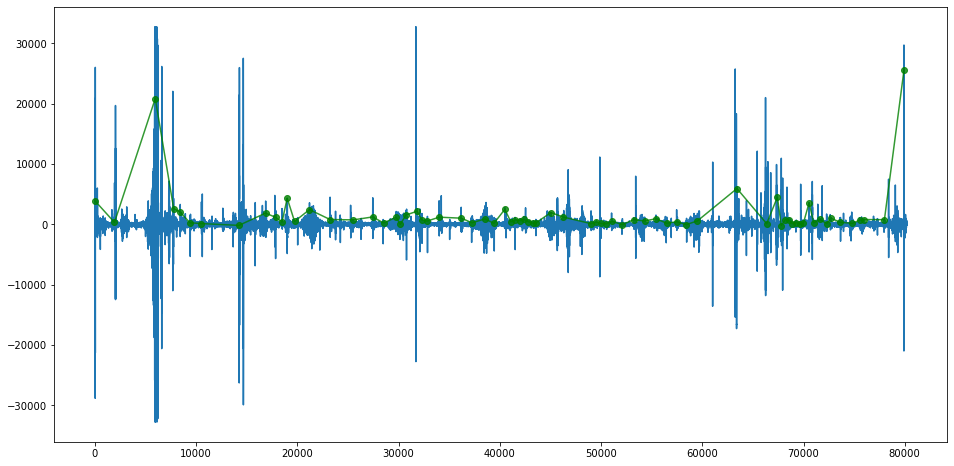

In [177]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(datos[1])
plt.plot(tmp_interval, seq1[tmp_interval], marker="o", c='green', alpha=.8 )
plt.show()

In [178]:
tmp_interval2 = np.diff(tmp_interval)

In [179]:
tmp_interval2

array([1915, 4032, 1817,  655,  949, 1135, 3707, 2642, 1007,  607,  517,
        725, 1473, 2031, 2298, 1922, 1076, 1239,  404,  576, 1095,  449,
        535, 1180, 2184, 1074, 1281,  880, 1079,  588,  461,  475,  344,
        423,  492,  332, 1433, 1245, 2719,  542,  416,  511,  635,  997,
       1121, 1075, 1115, 1062,  984,  965, 1089, 3911, 2933, 1060,  383,
        407,  363,  319,  391,  378,  322,  572,  447,  601,  687,  422,
        916, 1203,  765,  394, 2005, 1933])

In [137]:
i = 1
fname = root_dir + '/training_data/' + fnms_wav[i]
print(fname)
datos=sp.io.wavfile.read(fname)
filtros=sio.loadmat('./Filters1')
tmp_interval = []
n_samp = len(datos[1])//per_sec



for k in range(n_samp):
    X = datos[1][k*per_sec:(k+1)*per_sec]
    Fs= datos[0]
    Fpa20=filtros['Fpa20'];			        # High pass filter
    Fpa20=Fpa20[0];					# High pass filter
    Fpb100=filtros['Fpb100'];		        # Low-pass Filter
    Fpb100=Fpb100[0];				# Low-pass Filter
    Xf=FpassBand(X,Fpa20,Fpb100); 	                # Apply a passband filter
    Xf=vec_nor(Xf);			

# Derivate of the Signal
    dX=derivate(Xf);				# Derivate of the signal
    dX=vec_nor(dX);					# Vector Normalizing
# Square of the signal
    dy=np.square(Xf);
    dy=vec_nor(dy);

    size=np.shape(Xf)				# Rank or dimension of the array
    fil=size[0];					# Number of rows

    positive=np.zeros((1,fil+1));                   # Initializating Positives Values Vector 
    positive=positive[0];                           # Getting the Vector

    points=np.zeros((1,fil));                       # Initializating the all Peak Points Vector
    points=points[0];                               # Getting the point vector

    peaks=np.zeros((1,fil));                        # Initializating the s1-s1 Peak Vector
    peaks=peaks[0];                                 # Getting the point vector


    for i in range(0,fil):
        if dX[i]>0:
            positive[i]=1;
        else:
            positive[i]=0;

    for i in range(0,fil):
        if (positive[i]==1 and positive[i+1]==0):
            points[i]=Xf[i];
        else:
            points[i]=0;

    indexes=peakutils.indexes(points,thres=0.5/max(points), min_dist=min_dist);
    lenght=np.shape(indexes)			# Get the length of the index vector		
    lenght=lenght[0];				# Get the value of the index vector

    for i in range(0,lenght):
        p=indexes[i];
        peaks[p]=points[p];

    n=np.arange(0,fil);                            # Vector to the X axes (Number of Samples)
    indexes =indexes+(k*per_sec)    
    tmp_peaks = np.array(indexes)


    tmp_interval.extend(tmp_peaks)

tmp_interval = np.array(tmp_interval)

/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/13918_MV.wav


In [138]:
datos[1]

array([-1812, -1872,  -547, ...,  -937,  -894,  -592], dtype=int16)

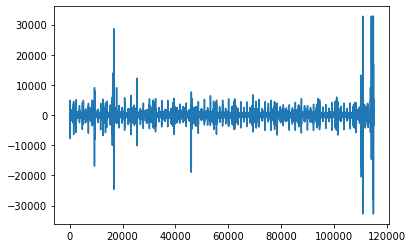

In [139]:
import matplotlib.pyplot as plt

plt.plot(datos[1])
plt.show()

In [140]:
tmp_interval

array([   191,   1458,   2508,   4821,   5194,   7106,   9413,  10666,
        11747,  12968,  14028,  15214,  16754,  20932,  22278,  22713,
        23240,  24505,  24827,  25565,  26810,  27878,  29144,  30182,
        32497,  33758,  34831,  36054,  37111,  38390,  39444,  40716,
        41786,  42953,  44082,  45319,  46020,  46369,  48679,  50980,
        52201,  53255,  55557,  56720,  57865,  59078,  60134,  61380,
        62434,  63683,  64750,  67037,  68268,  69325,  70516,  71648,
        72876,  73945,  75183,  76225,  77471,  78516,  79679,  80826,
        81968,  83089,  84334,  85371,  86620,  87666,  88831,  89973,
        91206,  92257,  93433,  94547,  95806,  96882,  98110,  99160,
       100347, 101465, 102727, 103794, 106068, 107323, 108368, 109620,
       110450, 110891, 111396])

In [141]:
seq1 = np.array(datos[1])

In [142]:
seq1[tmp_interval]

array([ 3994,  2476,  5094,  4039,  -135,  1932,  3630,  1723,  2971,
        1096,  3311,  2410,  5745,  3782,  1495,   779,  5798,  2297,
        1533,  2224,  1303,  3942,   119,  5053,  3606,  1627,  4062,
         805,  4116,  1516,  4441,  2059,  2983,  1320,  3813,  1184,
        7180,  5087,  2731,  5210,  1940,  5815,  3013,  2256,  4304,
         733,  4939,  1010,  5359,  1565,  4416,  3273,   674,  5187,
        2277,  4837,  2023,  1634,    63,  3365,  3773,  2662,  1948,
        1204,  1965,  2427,   167,  3014,  1077,  5244,   353,  1469,
        1583,  2981,  -142,  2272,  2254,  1277,  2051,  2430,  3123,
        -100,  1684,   756,  2650,   466,  1956,  2219,  5387, 30230,
        1369], dtype=int16)

## MV

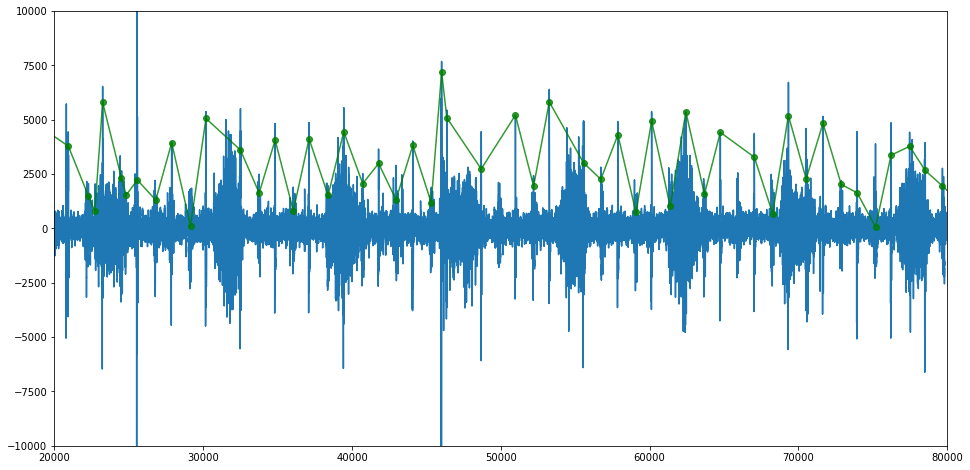

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(datos[1])
plt.plot(tmp_interval, seq1[tmp_interval], marker="o", c='green', alpha=.8 )
plt.xlim(20000,80000)
plt.ylim(-10000,10000)
plt.show()

In [147]:
tmp_interval2 = np.diff(tmp_interval)

In [148]:
tmp_interval2

array([1267, 1050, 2313,  373, 1912, 2307, 1253, 1081, 1221, 1060, 1186,
       1540, 4178, 1346,  435,  527, 1265,  322,  738, 1245, 1068, 1266,
       1038, 2315, 1261, 1073, 1223, 1057, 1279, 1054, 1272, 1070, 1167,
       1129, 1237,  701,  349, 2310, 2301, 1221, 1054, 2302, 1163, 1145,
       1213, 1056, 1246, 1054, 1249, 1067, 2287, 1231, 1057, 1191, 1132,
       1228, 1069, 1238, 1042, 1246, 1045, 1163, 1147, 1142, 1121, 1245,
       1037, 1249, 1046, 1165, 1142, 1233, 1051, 1176, 1114, 1259, 1076,
       1228, 1050, 1187, 1118, 1262, 1067, 2274, 1255, 1045, 1252,  830,
        441,  505])

In [72]:
for k in range(n_samp):
    X = datos[1][k*per_sec:(k+1)*per_sec]
    Fs= datos[0]
    Fpa20=filtros['Fpa20'];			        # High pass filter
    Fpa20=Fpa20[0];					# High pass filter
    Fpb100=filtros['Fpb100'];		        # Low-pass Filter
    Fpb100=Fpb100[0];				# Low-pass Filter
    Xf=FpassBand(X,Fpa20,Fpb100); 	                # Apply a passband filter
    Xf=vec_nor(Xf);			

# Derivate of the Signal
    dX=derivate(Xf);				# Derivate of the signal
    dX=vec_nor(dX);					# Vector Normalizing
# Square of the signal
    dy=np.square(Xf);
    dy=vec_nor(dy);

    size=np.shape(Xf)				# Rank or dimension of the array
    fil=size[0];					# Number of rows

    positive=np.zeros((1,fil+1));                   # Initializating Positives Values Vector 
    positive=positive[0];                           # Getting the Vector

    points=np.zeros((1,fil));                       # Initializating the all Peak Points Vector
    points=points[0];                               # Getting the point vector

    peaks=np.zeros((1,fil));                        # Initializating the s1-s1 Peak Vector
    peaks=peaks[0];                                 # Getting the point vector


    for i in range(0,fil):
        if dX[i]>0:
            positive[i]=1;
        else:
            positive[i]=0;

    for i in range(0,fil):
        if (positive[i]==1 and positive[i+1]==0):
            points[i]=Xf[i];
        else:
            points[i]=0;

    indexes=peakutils.indexes(points,thres=0.5/max(points), min_dist=min_dist);
    lenght=np.shape(indexes)			# Get the length of the index vector		
    lenght=lenght[0];				# Get the value of the index vector

    for i in range(0,lenght):
        p=indexes[i];
        peaks[p]=points[p];

    n=np.arange(0,fil);                            # Vector to the X axes (Number of Samples)
    indexes =indexes+(k*per_sec)    
    tmp_peaks = np.array(indexes)


    tmp_interval.extend(tmp_peaks)

tmp_interval = np.array(tmp_interval)
tmp_interval = np.diff(tmp_interval)

#tmp_total_interval.append(tmp_interval)



In [73]:
tmp_interval

array([1047, 1214, 1031, 2274, 2253, 1206, 1031, 1224, 1035, 2274])

In [38]:
tmp_peaks

array([ 96882,  99160, 100347, 101465, 103794, 106068, 107323, 108368,
       109620, 110349, 110891, 111396])

In [30]:
indexes

array([108368, 109620, 110349, 110891, 111396])

In [ ]:
    tmp_total_interval = [] 

In [46]:
peakutils.indexes

AttributeError: module 'peakutils' has no attribute 'indexes'

In [43]:
k = 0 
X = datos[1][k*per_sec:(k+1)*per_sec]
Fs= datos[0]
Fpa20=filtros['Fpa20'];			        # High pass filter
Fpa20=Fpa20[0];					# High pass filter
Fpb100=filtros['Fpb100'];		        # Low-pass Filter
Fpb100=Fpb100[0];				# Low-pass Filter
Xf=FpassBand(X,Fpa20,Fpb100); 	                # Apply a passband filter
Xf=vec_nor(Xf);			

# Derivate of the Signal
dX=derivate(Xf);				# Derivate of the signal
dX=vec_nor(dX);					# Vector Normalizing
# Square of the signal
dy=np.square(Xf);
dy=vec_nor(dy);

size=np.shape(Xf)				# Rank or dimension of the array
fil=size[0];					# Number of rows

positive=np.zeros((1,fil+1));                   # Initializating Positives Values Vector 
positive=positive[0];                           # Getting the Vector

points=np.zeros((1,fil));                       # Initializating the all Peak Points Vector
points=points[0];                               # Getting the point vector

peaks=np.zeros((1,fil));                        # Initializating the s1-s1 Peak Vector
peaks=peaks[0];                                 # Getting the point vector


for i in range(0,fil):
    if dX[i]>0:
        positive[i]=1;
    else:
        positive[i]=0;

for i in range(0,fil):
    if (positive[i]==1 and positive[i+1]==0):
        points[i]=Xf[i];
    else:
        points[i]=0;



In [45]:
positive

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
indexes=peakutils.indexes(points,thres=0.5/max(points), min_dist=min_dist);
lenght=np.shape(indexes)			# Get the length of the index vector		
lenght=lenght[0];				# Get the value of the index vector

for i in range(0,lenght):
    p=indexes[i];
    peaks[p]=points[p];

n=np.arange(0,fil);                            # Vector to the X axes (Number of Samples)
indexes =indexes+(k*per_sec)    
tmp_peaks = np.array(indexes)


tmp_interval.extend(tmp_peaks)


In [38]:
peakutils

<module 'peakutils' (namespace)>

In [ ]:
 if use_interval :
                
                datos=sp.io.wavfile.read(filename)
                filtros=sio.loadmat('./Filters1')
                tmp_interval = []
                n_samp = len(datos[1])//per_sec
                               
                
                try:
                    for k in range(n_samp):
                        X = datos[1][k*per_sec:(k+1)*per_sec]
                        Fs= datos[0]
                        Fpa20=filtros['Fpa20'];			        # High pass filter
                        Fpa20=Fpa20[0];					# High pass filter
                        Fpb100=filtros['Fpb100'];		        # Low-pass Filter
                        Fpb100=Fpb100[0];				# Low-pass Filter
                        Xf=FpassBand(X,Fpa20,Fpb100); 	                # Apply a passband filter
                        Xf=vec_nor(Xf);			
            
            # Derivate of the Signal
                        dX=derivate(Xf);				# Derivate of the signal
                        dX=vec_nor(dX);					# Vector Normalizing
            # Square of the signal
                        dy=np.square(Xf);
                        dy=vec_nor(dy);
                    
                        size=np.shape(Xf)				# Rank or dimension of the array
                        fil=size[0];					# Number of rows

                        positive=np.zeros((1,fil+1));                   # Initializating Positives Values Vector 
                        positive=positive[0];                           # Getting the Vector

                        points=np.zeros((1,fil));                       # Initializating the all Peak Points Vector
                        points=points[0];                               # Getting the point vector

                        peaks=np.zeros((1,fil));                        # Initializating the s1-s1 Peak Vector
                        peaks=peaks[0];                                 # Getting the point vector

            
                        for i in range(0,fil):
                            if dX[i]>0:
                                positive[i]=1;
                            else:
                                positive[i]=0;
    
                        for i in range(0,fil):
                            if (positive[i]==1 and positive[i+1]==0):
                                points[i]=Xf[i];
                            else:
                                points[i]=0;

                        indexes=peakutils.indexes(points,thres=0.5/max(points), min_dist=min_dist);
                        lenght=np.shape(indexes)			# Get the length of the index vector		
                        lenght=lenght[0];				# Get the value of the index vector

                        for i in range(0,lenght):
                            p=indexes[i];
                            peaks[p]=points[p];
        
                        n=np.arange(0,fil);                            # Vector to the X axes (Number of Samples)
                        indexes =indexes+(k*per_sec)    
                        tmp_peaks = np.array(indexes)
                    
                    
                        tmp_interval.extend(tmp_peaks)
                    
                    tmp_interval = np.array(tmp_interval)
                    tmp_interval = np.diff(tmp_interval)
                    
                    tmp_total_interval.append(tmp_interval)
 
           
                except:
                    print(filename)
                    tmp_peaks = np.zeros(max_interval_len)
                    tmp_total_interval.append(tmp_peaks)
                    
            else :
                        
                tmp_peaks = np.zeros(max_interval_len)
                tmp_total_interval.append(tmp_peaks)               
            